# Step 1: Install Required Libraries

In [2]:
# Install the required packages if they are not already installed
#!pip install torch torchvision torchaudio
!pip install datasets
!pip install transformers
!pip install sentencepiece
!pip install nltk
!pip install rouge
!pip install spacy

  Using cached pyarrow-15.0.2-cp310-cp310-win_amd64.whl.metadata (3.1 kB)
  Using cached pyarrow_hotfix-0.6-py3-none-any.whl.metadata (3.6 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.2.2-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached xxhash-3.4.1-cp310-cp310-win_amd64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl.metadata (7.2 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached frozenlist-1.4.1-cp310-cp310-win_amd64.whl.metadata (12 kB)
  Using cached multidict-6.0.5-cp310-cp310-win_amd64.whl.metadata (4.3 kB)
  Using cached yarl-1.9.4-cp310-cp310-win_amd64.whl.metadata (32 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl.metadata (4.2 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/542.0 kB ? eta -:--:--
   -------------------- ------------------- 276.5/542.0 kB 8.6 MB/s eta 0:00:01
   -----

In [1]:
import torch
import numpy as np
from datasets import load_dataset
import sentencepiece as spm
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import torch.nn as nn
import random
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Step 2a: Load and Prepare the Dataset


In [3]:
# Ensure all necessary libraries are imported
import torch
from datasets import load_dataset

# Setting the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to filter the dataset based on story length and duplication
def filter_dataset(data):
    story_length = len(data['story'].split())
    is_length_valid = story_length <= 100  # Keeping story length <= 100
    is_not_duplicate = data['prompt'] != data['story']  # Ensure prompt is not the same as story
    return is_length_valid and is_not_duplicate

# Load the WritingPrompts dataset from HuggingFace datasets
dataset = load_dataset("euclaise/writingprompts")

# Filter the dataset
filtered_dataset = {split: dataset[split].filter(filter_dataset) for split in dataset.keys()}

# Function to check the percentage of the dataset in each split after filtering
def check_split_percentage(dataset):
    total_entries = sum(dataset[split].num_rows for split in dataset.keys())
    for split in dataset.keys():
        split_percentage = (dataset[split].num_rows / total_entries) * 100
        print(f"{split}: {split_percentage:.2f}% of the total dataset")

# Execute the function to display dataset splits
check_split_percentage(filtered_dataset)


train: 91.04% of the total dataset
test: 5.97% of the total dataset
validation: 2.99% of the total dataset


# Step 2b: Check Dataset Size

In [4]:
# Function to check the size of the dataset in each split after filtering
def check_dataset_size(dataset):
    total_entries = sum(dataset[split].num_rows for split in dataset.keys())
    print(f"Total number of entries across all splits: {total_entries}")
    for split in dataset.keys():
        num_entries = dataset[split].num_rows
        split_percentage = (num_entries / total_entries) * 100
        print(f"{split} has {num_entries} entries, which is {split_percentage:.2f}% of the total dataset")

# Execute the function to display dataset sizes
check_dataset_size(filtered_dataset)


Total number of entries across all splits: 201
train has 183 entries, which is 91.04% of the total dataset
test has 12 entries, which is 5.97% of the total dataset
validation has 6 entries, which is 2.99% of the total dataset


# Step 3: Tokenization

In [5]:
# Import necessary libraries for SentencePiece tokenization
import sentencepiece as spm

# Concatenate all prompts and stories to train the SentencePiece model
def create_combined_text_file(dataset, file_path='writingprompts_combined.txt'):
    with open(file_path, 'w', encoding='utf-8') as outfile:
        for split in dataset.keys():
            for data in dataset[split]:
                combined_text = data['prompt'] + " " + data['story']
                outfile.write(combined_text + '\n')

# Call the function to create the combined text file
create_combined_text_file(filtered_dataset)

# Train SentencePiece model
spm.SentencePieceTrainer.train(
    input='writingprompts_combined.txt',
    model_prefix='writingprompts_sentencepiece',
    vocab_size=18833,  # Vocab size can be adjusted based on requirements
    character_coverage=0.9995,
    model_type='bpe'  # Byte pair encoding
)

# Load the trained SentencePiece model
sp = spm.SentencePieceProcessor()
sp.load('writingprompts_sentencepiece.model')

# Define function to encode data using SentencePiece
def encode_data(data):
    data['input_ids'] = sp.encode_as_ids(data['prompt'] + " [EOS]")
    data['labels'] = sp.encode_as_ids("[SOS] " + data['story'] + " [EOS]")
    return data

# Apply encoding to each split in the dataset
encoded_dataset = {split: filtered_dataset[split].map(encode_data) for split in filtered_dataset.keys()}

# Step 4: Define the Sequence-to-Sequence Model with LSTM and Attention


This code block defines an encoder with bidirectional LSTM, an attention mechanism, and a decoder that utilizes the computed attention weights. The Seq2Seq model orchestrates how data flows from the encoder to the decoder, using teacher forcing during training.

In [21]:
# Define the encoder class
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, enc_hid_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)  # Transform to decoder hidden size
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))).unsqueeze(0)
        cell = torch.tanh(self.fc(torch.cat((cell[-2,:,:], cell[-1,:,:]), dim=1))).unsqueeze(0)

        return outputs, hidden, cell

# Define the attention class
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        print("Shapes before concatenation:")
        print("Hidden:", hidden.shape)
        print("Encoder outputs:", encoder_outputs.shape)

        # Repeat the hidden state to match the batch size of encoder_outputs
        hidden = hidden.permute(1, 0, 2)
        hidden = hidden.repeat(1, encoder_outputs.shape[1], 1)

        # Concatenate along the last dimension (features dimension)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        print("Shape after concatenation:", energy.shape)

        # Compute the attention weights
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)



# Define the decoder class
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # Ensure emb_dim aligns with the weighted tensor's feature size
        self.align_features = nn.Linear(emb_dim, enc_hid_dim * 2)  # Adjust emb_dim to match enc_hid_dim * 2
        self.rnn = nn.LSTM((enc_hid_dim * 2) + (enc_hid_dim * 2), dec_hid_dim, batch_first=True)
        self.fc_out = nn.Linear(dec_hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)  # Ensure input is [batch size, 1]
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        # Flatten the embedded tensor to [batch size, 1, emb_dim] and align dimensions
        embedded = embedded.view(embedded.size(0), 1, -1)
        embedded = self.align_features(embedded)  # Adjust embedding dimension to match weighted

        # Print dimensions for debugging
        print("Post alignment Embedded size:", embedded.shape)

        # Attention processing
        a = self.attention(hidden, encoder_outputs)  # Compute attention weights
        a = a.unsqueeze(1)  # Adjust shape for batch matrix multiplication
        weighted = torch.bmm(a, encoder_outputs)  # Apply attention weights

        # Print dimensions for debugging
        print("Weighted size:", weighted.shape)
        
        # Check dimensions before concatenation
        if embedded.shape != weighted.shape:
            raise ValueError(f"Dimension mismatch: embedded {embedded.shape}, weighted {weighted.shape}")

        rnn_input = torch.cat((embedded, weighted), dim=2)  # Concatenate along the feature dimension
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))

        return prediction, hidden, cell


# Define the Seq2Seq model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len = trg.shape[1]
        batch_size = trg.shape[0]  # Add this line to get the batch size
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)  # Correct initialization
        encoder_outputs, hidden, cell = self.encoder(src)

        # First input to the decoder is the <sos> tokens
        input = trg[:, 0]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:, t] = output  # Ensure output tensor has the correct shape
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[:, t] if teacher_force else output.argmax(1)

        return outputs


# Parameters and instantiation
INPUT_DIM = len(sp)
OUTPUT_DIM = len(sp)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

#attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
#enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
#dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

#model = Seq2Seq(enc, dec, device).to(device)

# Instantiate the Bi-LSTM model
bi_lstm_encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
attention = Attention(ENC_HID_DIM, DEC_HID_DIM)
bi_lstm_decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attention)
bilstm_model = Seq2Seq(bi_lstm_encoder, bi_lstm_decoder, device).to(device)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset
import sentencepiece as spm
import random
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, emb_dim, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, emb_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2).float() * (-math.log(10000.0) / emb_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, emb_dim, n_heads, hidden_dim, dropout):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attention = nn.MultiheadAttention(emb_dim, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(emb_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, emb_dim)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        src2, _ = self.self_attention(src, src, src)
        src = src + self.dropout(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(torch.relu(self.linear1(src))))
        src = src + self.dropout(src2)
        src = self.norm2(src)
        return src

class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, n_heads, hidden_dim, n_layers, dropout):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.positional_encoding = PositionalEncoding(emb_dim, dropout)
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(emb_dim, n_heads, hidden_dim, dropout)
            for _ in range(n_layers)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.embedding(src) * math.sqrt(self.embedding.embedding_dim)
        embedded = self.positional_encoding(embedded)
        x = self.dropout(embedded)
        for layer in self.layers:
            x = layer(x)
        return x

class Seq2Seq(nn.Module):
    def __init__(self, encoder, device, decoder=None):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg=None, teacher_forcing_ratio=0.5):
        if self.decoder is not None:
            # Case for models with decoder (like Bi-LSTM)
            batch_size = trg.shape[0]
            trg_len = trg.shape[1]
            trg_vocab_size = self.decoder.output_dim
            outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
            encoder_output = self.encoder(src)

            input = trg[:, 0]  # <sos> token
            for t in range(1, trg_len):
                output, _, _ = self.decoder(input, encoder_output)
                outputs[:, t] = output
                teacher_force = random.random() < teacher_forcing_ratio
                top1 = output.argmax(1)
                input = trg[:, t] if teacher_force else top1
            return outputs
        else:
            # Case for models without decoder (like Transformer)
            return self.encoder(src)

In [8]:
# Instantiate the Transformer encoder
N_HEADS = 8  # Define the number of attention heads
N_LAYERS = 6  # Define the number of transformer layers
HIDDEN_DIM = 2048  # Define the hidden dimension size
transformer_encoder = TransformerEncoder(INPUT_DIM, ENC_EMB_DIM, N_HEADS, HIDDEN_DIM, N_LAYERS, ENC_DROPOUT)
transformer_model = Seq2Seq(transformer_encoder, device).to(device)

# Step 5: Training Setup


This cell prepares data loaders that will be used to feed data into the model during training and evaluation. The collate_fn function handles padding of sequences to ensure they are of uniform length within a batch.

In [9]:
from torch.nn.utils.rnn import pad_sequence

# Function to collate data samples into batches
def collate_fn(batch):
    inputs = [item['input_ids'] for item in batch]
    targets = [item['labels'] for item in batch]

    inputs_padded = pad_sequence([torch.tensor(seq) for seq in inputs], 
                                 padding_value=sp.piece_to_id('[PADDING]'), 
                                 batch_first=True)
    targets_padded = pad_sequence([torch.tensor(seq) for seq in targets], 
                                  padding_value=sp.piece_to_id('[PADDING]'), 
                                  batch_first=True)

    return inputs_padded, targets_padded

# DataLoader for each dataset split
batch_size = 32
train_loader = DataLoader(encoded_dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(encoded_dataset['validation'], batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(encoded_dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Step 6: Define the Training Function


This code sets up functions for training and evaluating the model. train is used during the training phase to adjust the model weights, while evaluate is used to assess the model's performance on validation and test sets without making any adjustments to the weights.

In [10]:
# Define training function for both Bi-LSTM and Transformer models
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for src, trg in iterator:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)

        # Flatten output for cross-entropy loss calculation
        output_dim = output.shape[-1]
        output_flattened = output.contiguous().view(-1, output_dim)
        trg_flattened = trg[:, 1:].contiguous().view(-1)

        # Ensure that output and trg have the same total length
        if output_flattened.shape[0] != trg_flattened.shape[0]:
            raise ValueError(f"Mismatch in flattened shapes: output {output_flattened.shape[0]}, target {trg_flattened.shape[0]}")

        # Calculate loss only on non-padding token positions
        non_pad_mask = trg_flattened != sp.piece_to_id('[PADDING]')
        output_masked = output_flattened[non_pad_mask]
        trg_masked = trg_flattened[non_pad_mask]

        loss = criterion(output_masked, trg_masked)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)



# Define evaluation function for both Bi-LSTM and Transformer models
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, trg in iterator:
            src, trg = src.to(device), trg.to(device)

            # Assume the model expects both src and trg for shape compatibility but does not use trg to generate output
            output = model(src, trg[:, :-1])  # Feed the target excluding the last element

            # Flatten the output and target for loss calculation
            output_flat = output.reshape(-1, output.shape[-1])
            trg_flat = trg[:, 1:].reshape(-1)  # Skip <sos> token and flatten

            # Apply mask to ignore the padding in loss calculation
            non_pad_mask = trg_flat != sp.piece_to_id('[PADDING]')
            output_masked = output_flat[non_pad_mask]
            trg_masked = trg_flat[non_pad_mask]

            loss = criterion(output_masked, trg_masked)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Step 7: Training the Model


* Set to 5 epochs
* Initializes the optimizer and loss criterion.
* Defines the number of training epochs and a gradient clipping threshold to prevent exploding gradients.
* Iterates over the set number of epochs, performing training and validation.
* Saves the model checkpoint if the validation loss improves.

### BI-LTSM & TRANSFORMER

In [11]:
n_epochs = 5
clip = 1

In [12]:
### import torch.optim as optim
import math
import matplotlib.pyplot as plt

# Setup the optimizer and loss function for Bi-LSTM model
optimizer_bilstm = optim.Adam(bilstm_model.parameters())
criterion_bilstm = nn.CrossEntropyLoss(ignore_index=sp.piece_to_id('[PADDING]'))

# Define hyperparameters
save_interval = 1  # Save every 2 epochs

# Track the loss and performance for Bi-LSTM model
train_losses_bilstm = []
valid_losses_bilstm = []
best_valid_loss_bilstm = float('inf')


# Inside the training loop for both models
for epoch in range(n_epochs):
    # Train Bi-LSTM model
    bilstm_model.train()  # Set the model to training mode
    epoch_loss_bilstm = 0

    for src, trg in train_loader:
        src = src.to(device)
        trg = trg.to(device)

        # Zero the gradients
        optimizer_bilstm.zero_grad()

        # Ensure that bilstm_model returns a tensor instead of a tuple
        output = bilstm_model(src, trg)  # output shape [batch size, trg len, output dim]

        # Reshape trg to 1D
        trg = trg[:, 1:].reshape(-1)

        # Align output reshaping
        output = output[:, :-1, :].reshape(-1, output.shape[-1])  # Align output reshaping

        # Create a mask for non-padding tokens to apply on trg
        mask = (trg != sp.piece_to_id('[PADDING]'))

        # Apply the mask to output and trg
        output_masked = output[mask]
        trg_masked = trg[mask]

        # Calculate loss only on non-padding token positions
        loss = criterion_bilstm(output_masked, trg_masked)

        # Backward pass
        loss.backward()

        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(bilstm_model.parameters(), clip)

        # Update weights
        optimizer_bilstm.step()

        epoch_loss_bilstm += loss.item()

    # Calculate average loss for the epoch for Bi-LSTM model
    train_loss_bilstm = epoch_loss_bilstm / len(train_loader)
    train_losses_bilstm.append(train_loss_bilstm)

    # Perform validation for Bi-LSTM model
    valid_loss_bilstm = evaluate(bilstm_model, valid_loader, criterion_bilstm)
    valid_losses_bilstm.append(valid_loss_bilstm)

    # Conditional saving based on improvement for Bi-LSTM model
    if valid_loss_bilstm < best_valid_loss_bilstm:
        best_valid_loss_bilstm = valid_loss_bilstm
        torch.save(bilstm_model.state_dict(), 'bilstm_model.pt')
        print(f"Bi-LSTM Model saved: Improved validation loss to {valid_loss_bilstm:.3f}")


    # Periodic saving regardless of improvement for both models
    if epoch % save_interval == 0:
        torch.save(bilstm_model.state_dict(), f'bilstm_model_epoch_{epoch}.pt')
        torch.save(transformer_model.state_dict(), f'transformer_model_epoch_{epoch}.pt')
        print(f"Models checkpoint saved at epoch {epoch}")

    # Print epoch results for both models
    print(f'Epoch: {epoch+1:02}')
    print(f'\tBi-LSTM Train Loss: {train_loss_bilstm:.3f} | Bi-LSTM Train PPL: {math.exp(train_loss_bilstm):7.3f}')
    print(f'\tBi-LSTM Val. Loss: {valid_loss_bilstm:.3f} | Bi-LSTM Val. PPL: {math.exp(valid_loss_bilstm):7.3f}')

Post alignment Embedded size: torch.Size([32, 1, 1024])
Shapes before concatenation:
Hidden: torch.Size([1, 32, 512])
Encoder outputs: torch.Size([32, 51, 1024])
Shape after concatenation: torch.Size([32, 51, 512])
Weighted size: torch.Size([32, 1, 1024])
Post alignment Embedded size: torch.Size([32, 1, 1024])
Shapes before concatenation:
Hidden: torch.Size([1, 32, 512])
Encoder outputs: torch.Size([32, 51, 1024])
Shape after concatenation: torch.Size([32, 51, 512])
Weighted size: torch.Size([32, 1, 1024])
Post alignment Embedded size: torch.Size([32, 1, 1024])
Shapes before concatenation:
Hidden: torch.Size([1, 32, 512])
Encoder outputs: torch.Size([32, 51, 1024])
Shape after concatenation: torch.Size([32, 51, 512])
Weighted size: torch.Size([32, 1, 1024])
Post alignment Embedded size: torch.Size([32, 1, 1024])
Shapes before concatenation:
Hidden: torch.Size([1, 32, 512])
Encoder outputs: torch.Size([32, 51, 1024])
Shape after concatenation: torch.Size([32, 51, 512])
Weighted size: to

### TEST ONLY ON TRANSFORMER

In [14]:
import torch
import torch.optim as optim
import torch.nn as nn

# Ensure the following lines are included before the training of Transformer model
train_losses_transformer = []
valid_losses_transformer = []

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, hidden_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=8, batch_first=True), 
            num_layers=6
        )
        self.output_layer = nn.Linear(hidden_dim, vocab_size)

    def forward(self, src):
        embedded = self.embedding(src)
        transformer_output = self.transformer_encoder(embedded)
        logits = self.output_layer(transformer_output)
        return logits

vocab_size = len(sp)
hidden_dim = 256
transformer_model = TransformerModel(vocab_size, hidden_dim).to(device)

optimizer_transformer = optim.Adam(transformer_model.parameters())
criterion_transformer = nn.CrossEntropyLoss(ignore_index=sp.piece_to_id('[PADDING]'))

# Initialize best_loss to a very high value so any initial training loss will be lower
best_loss = float('inf')

def evaluate(model, iterator, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, trg in iterator:
            src, trg = src.to(device), trg.to(device)
            output = model(src)
            trg = trg[:, 1:]  # Skip <sos> token
            if output.shape[1] > trg.shape[1]:
                output = output[:, :trg.shape[1], :]
            elif output.shape[1] < trg.shape[1]:
                trg = trg[:, :output.shape[1]]
            output_flat = output.contiguous().view(-1, vocab_size)
            trg_flat = trg.contiguous().view(-1)
            loss = criterion(output_flat, trg_flat)
            total_loss += loss.item()
    return total_loss / len(iterator)

for epoch in range(n_epochs):
    transformer_model.train()
    total_loss = 0
    for src, trg in train_loader:
        src, trg = src.to(device), trg.to(device)
        optimizer_transformer.zero_grad()
        output = transformer_model(src)
        trg = trg[:, 1:]  # Adjust for <sos>
        if output.shape[1] > trg.shape[1]:
            output = output[:, :trg.shape[1], :]
        elif output.shape[1] < trg.shape[1]:
            trg = trg[:, :output.shape[1]]
        output_flat = output.contiguous().view(-1, vocab_size)
        trg_flat = trg.contiguous().view(-1)
        loss = criterion_transformer(output_flat, trg_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(transformer_model.parameters(), clip)
        optimizer_transformer.step()
        total_loss += loss.item()
    
    average_loss = total_loss / len(train_loader)
    train_losses_transformer.append(average_loss)
    valid_loss = evaluate(transformer_model, valid_loader, criterion_transformer)
    valid_losses_transformer.append(valid_loss)
    
    print(f"Epoch {epoch+1}, Train Loss: {average_loss:.4f}, Valid Loss: {valid_loss:.4f}")
    
    if average_loss < best_loss:
        best_loss = average_loss
        torch.save(transformer_model.state_dict(), 'transformer_model.pt')
        print("Model saved with improvement in loss.")

torch.save(transformer_model.state_dict(), 'transformer_model_final.pt')
print("Final model saved.")

Epoch 1, Train Loss: 9.0125, Valid Loss: 8.1823
Model saved with improvement in loss.
Epoch 2, Train Loss: 7.4509, Valid Loss: 7.3006
Model saved with improvement in loss.
Epoch 3, Train Loss: 6.6282, Valid Loss: 7.1731
Model saved with improvement in loss.
Epoch 4, Train Loss: 6.4255, Valid Loss: 7.2913
Model saved with improvement in loss.
Epoch 5, Train Loss: 6.4078, Valid Loss: 7.3856
Model saved with improvement in loss.
Final model saved.


In [15]:
print(trg.shape)

torch.Size([23, 49])


# Step 8: Model Evaluation and Testing


   Epoch  Bi-LSTM Train Loss  Bi-LSTM Valid Loss  Transformer Train Loss  \
0      1            8.977051            7.411891                9.012468   
1      2            6.836327            7.150711                7.450864   
2      3            6.632424            7.356448                6.628227   
3      4            6.544219            7.478743                6.425494   
4      5            6.519058            7.552904                6.407796   

   Transformer Valid Loss  
0                8.182269  
1                7.300599  
2                7.173052  
3                7.291294  
4                7.385574  


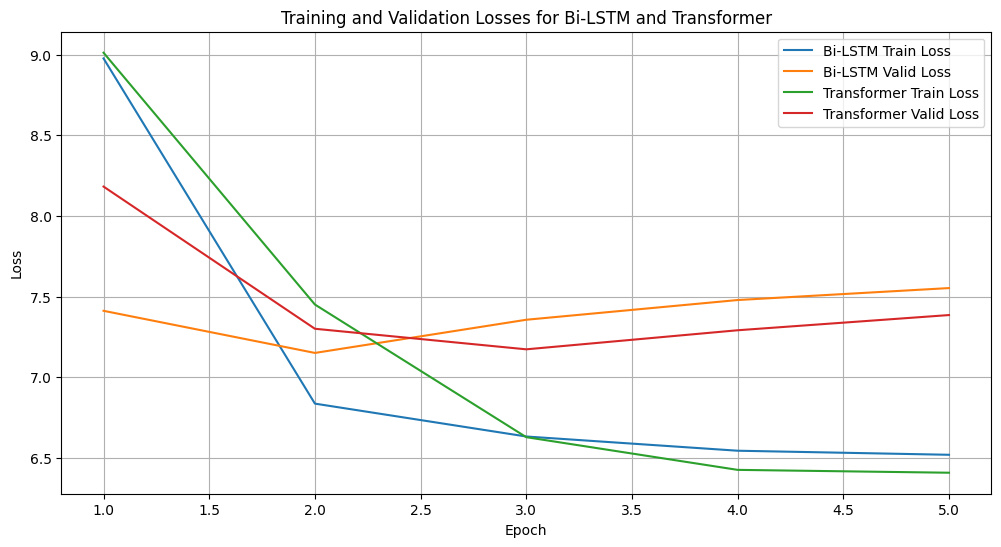

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume train_losses_bilstm, valid_losses_bilstm, train_losses_transformer, and valid_losses_transformer are defined

# Create DataFrames for Bi-LSTM and Transformer models
bi_lstm_loss_df = pd.DataFrame({
    'Epoch': range(1, len(train_losses_bilstm) + 1),
    'Bi-LSTM Train Loss': train_losses_bilstm,
    'Bi-LSTM Valid Loss': valid_losses_bilstm
})

transformer_loss_df = pd.DataFrame({
    'Epoch': range(1, len(train_losses_transformer) + 1),
    'Transformer Train Loss': train_losses_transformer,
    'Transformer Valid Loss': valid_losses_transformer
})

# Merge the two DataFrames on the 'Epoch' column
loss_df = pd.merge(bi_lstm_loss_df, transformer_loss_df, on='Epoch', how='outer')

# Ensure all rows are displayed (adjust as necessary)
pd.set_option('display.max_rows', None)

# Print the DataFrame
print(loss_df)

# Optionally plot the losses directly from the DataFrame
plt.figure(figsize=(12, 6))
for column in loss_df.columns[1:]:
    plt.plot(loss_df['Epoch'], loss_df[column], label=column)
plt.title('Training and Validation Losses for Bi-LSTM and Transformer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
import pandas as pd

# Create DataFrames for Bi-LSTM and Transformer models
bi_lstm_loss_df = pd.DataFrame({'Epoch': range(1, len(train_losses_bilstm) + 1),
                                'Bi-LSTM Train Loss': train_losses_bilstm,
                                'Bi-LSTM Valid Loss': valid_losses_bilstm})

transformer_loss_df = pd.DataFrame({'Epoch': range(1, len(train_losses_transformer) + 1),
                                     'Transformer Train Loss': train_losses_transformer,
                                     'Transformer Valid Loss': valid_losses_transformer})

# Merge the two DataFrames on the 'Epoch' column
loss_df = pd.merge(bi_lstm_loss_df, transformer_loss_df, on='Epoch', how='outer')

# Print the DataFrame
loss_df

,Epoch,Bi-LSTM Train Loss,Bi-LSTM Valid Loss,Transformer Train Loss,Transformer Valid Loss
0,1,8.977051,7.411891,9.012468,8.182269
1,2,6.836327,7.150711,7.450864,7.300599
2,3,6.632424,7.356448,6.628227,7.173052
3,4,6.544219,7.478743,6.425494,7.291294
4,5,6.519058,7.552904,6.407796,7.385574


# Step 9: Generating Sample Text and Model Evaluation


### 1. Generating Text using Bi-LTSM

In [23]:
def generate_text(bilstm_model, src_input, sp, max_len=100):
    bilstm_model.eval()
    with torch.no_grad():
        src_tensor = torch.LongTensor(src_input).unsqueeze(0).to(device)

        # Initialize with the start of sequence token
        trg_indexes = [sp.piece_to_id('[SOS]')]
        
        # Initialize hidden and cell state
        encoder_outputs, hidden, cell = bilstm_model.encoder(src_tensor)

        for i in range(max_len):
            trg_tensor = torch.LongTensor([trg_indexes[-1]]).unsqueeze(0).to(device)
            output, hidden, cell = bilstm_model.decoder(trg_tensor, hidden, cell, encoder_outputs)
            
            print("Output tensor shape:", output.shape)  # Debugging statement
            pred_token = output.argmax(-1).item()  # Remove the unnecessary slicing
            if pred_token == sp.piece_to_id('[EOS]'):
                break
            trg_indexes.append(pred_token)

        trg_tokens = [sp.id_to_piece(i) for i in trg_indexes]
        return trg_tokens[1:]  # Skip the initial [SOS] token

In [24]:
prompt = "It was a dark and stormy night"
prompt_ids = sp.encode_as_ids(prompt + ' [EOS]')  # Encode the prompt to ids

# Generate text based on the encoded prompt
generated_text = generate_text(bilstm_model, prompt_ids, sp)

Post alignment Embedded size: torch.Size([1, 1, 1024])
Shapes before concatenation:
Hidden: torch.Size([1, 1, 512])
Encoder outputs: torch.Size([1, 11, 1024])
Shape after concatenation: torch.Size([1, 11, 512])
Weighted size: torch.Size([1, 1, 1024])
Output tensor shape: torch.Size([1, 18833])
Post alignment Embedded size: torch.Size([1, 1, 1024])
Shapes before concatenation:
Hidden: torch.Size([1, 1, 512])
Encoder outputs: torch.Size([1, 11, 1024])
Shape after concatenation: torch.Size([1, 11, 512])
Weighted size: torch.Size([1, 1, 1024])
Output tensor shape: torch.Size([1, 18833])
Post alignment Embedded size: torch.Size([1, 1, 1024])
Shapes before concatenation:
Hidden: torch.Size([1, 1, 512])
Encoder outputs: torch.Size([1, 11, 1024])
Shape after concatenation: torch.Size([1, 11, 512])
Weighted size: torch.Size([1, 1, 1024])
Output tensor shape: torch.Size([1, 18833])
Post alignment Embedded size: torch.Size([1, 1, 1024])
Shapes before concatenation:
Hidden: torch.Size([1, 1, 512])

In [25]:
# Convert list of tokens to string
generated_text_str = ' '.join(generated_text)
print("Generated Text:", generated_text_str)

Generated Text: pOK wOcHb oD bender adows ▁courtyard per avi ▁approx ▁tre RE fFf lim ▁disrupts qVS tg ▁streaking ▁vocabulary ▁known icycle nt ▁sub irgin hees ▁lie ▁stick arr versat ,0 spike OOTZJjr ▁facs versat ▁narrit ▁unimaginably onflies ▁why ▁ultimate traction ieter ▁Chann ples ▁berry nd urri nd ChIi zXNr Our ▁inappropri ▁shar eQ ▁car vered uals amble arel ▁societ ▁case ▁winter clude kempt -0 SFW fth ▁loat ▁Covered ▁ran vad umbl oda ipsis ▁Ja ▁sinis ▁saliva ▁supr nim ▁torturous ▁sync ary ▁boar ▁yard SF 0182 ▁tattooed air dG GD ood enar ▁dow kway ▁Foot ▁last bou nch carded ipi ▁rainbow MojRUy


### 2. Generating Text using Transformer

In [26]:
# Instantiate the Transformer encoder
N_HEADS = 8  # Define the number of attention heads
N_LAYERS = 6  # Define the number of transformer layers
HIDDEN_DIM = 2048  # Define the hidden dimension size
transformer_encoder = TransformerEncoder(INPUT_DIM, ENC_EMB_DIM, N_HEADS, HIDDEN_DIM, N_LAYERS, ENC_DROPOUT)
transformer_model = Seq2Seq(transformer_encoder, device).to(device)

In [27]:
def temperature_sampling(logits, temperature=0.7):
    probs = torch.nn.functional.softmax(logits / temperature, dim=-1)
    return torch.multinomial(probs, num_samples=1).item()

def generate_text(transformer_model, src_input, sp, max_len=100, temperature=0.7):
    transformer_model.eval()
    with torch.no_grad():
        src_tensor = torch.LongTensor(src_input).unsqueeze(0).to(device)
        trg_indexes = [sp.piece_to_id('[SOS]')]  # Start token

        for i in range(max_len):
            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
            output = transformer_model(trg_tensor)
            logits = output[0, -1, :]  # Get the logits of the last output token
            pred_token = temperature_sampling(logits, temperature)

            if pred_token == sp.piece_to_id('[EOS]') or len(trg_indexes) >= max_len:
                break
            trg_indexes.append(pred_token)

        trg_tokens = [sp.id_to_piece(id) for id in trg_indexes[1:]]  # Skip the SOS token
        return ' '.join(trg_tokens)

# Example usage
prompt = "It was a dark and stormy night"
prompt_ids = sp.encode_as_ids(prompt)  # Encode the prompt to ids
prompt_ids.append(sp.piece_to_id('[EOS]'))

# Generate text based on the encoded prompt
generated_text = generate_text(transformer_model, prompt_ids, sp, max_len=100, temperature=0.8)
print("Generated Text:", generated_text)

Generated Text: ▁m ▁into ac in ▁B ▁his ill ▁that ▁their ▁man ▁WP ▁re is ▁g is ▁fe ly ▁you em ▁B ▁he ▁me ▁into ▁re ver ed est is ou ▁A ▁my ▁o ▁k ds ▁' an own it pp ▁am rit ▁l ld ▁b ▁le ▁on ▁lo ▁had ▁The ou ▁and ▁] ▁words ack ▁ha ▁B ▁into ing ck ot ds ▁they red st ly ous ▁th ic ess ▁her er ir ct ▁re ▁do ▁re ck ust ▁r le ▁sp ble ▁I em ▁Y art <s> ra er ▁my ou rit ame ▁are ▁no om ies 00 em


### Analysis of Generated Text

The generated text produced by the model appears to be nonsensical and lacks coherence with the given prompt. Several factors could contribute to this issue:

#### Model Complexity
The current model architecture or parameters may not be suitable for the task, leading to poor text generation performance. Further experimentation with different architectures or more complex models might be necessary to improve results.

#### Training Data Quality
The quality and diversity of the training data play a crucial role in the model's performance. If the training data lacks relevant examples or contains inconsistencies, the model may struggle to generate meaningful text. It's essential to ensure that the training data is diverse and representative of the desired output.

#### Training Duration
Training the model for a limited number of epochs may not provide sufficient time for it to learn meaningful patterns and relationships in the data. Increasing the number of training epochs or optimizing the training process could potentially lead to better text generation results.
```python
n_epochs = 10  # Increase the number of training epochs
```

#### Hyperparameters Tuning
Fine-tuning hyperparameters such as learning rate, batch size, and model architecture can significantly impact the model's performance. Experimenting with different hyperparameter configurations may help improve the quality of the generated text.
```python
batch_size = 32  # Adjust the batch size
```
#### Tokenization and Encoding
Issues with tokenization or encoding of the input data could result in mismatches between the input prompt and the model's internal representations, leading to nonsensical output. Double-checking the tokenization process and ensuring consistency in data preprocessing might help address this issue.

```python
prompt_ids = tokenizer.encode(prompt_text)  # Check tokenization of prompt text
```
In conclusion, further experimentation and optimization of the model, training process, and data preprocessing techniques are necessary to enhance the quality of the generated text.


In [384]:
import torch
import torch.nn as nn
import random

# Define encoder, attention, decoder, and Seq2Seq classes here

def generate_text(model, src_input, sp, max_len=100):
    model.eval()
    with torch.no_grad():
        src_tensor = torch.LongTensor(src_input).unsqueeze(0).to(device)
        encoder_outputs, hidden, cell = model.encoder(src_tensor)

        trg_indexes = [sp.piece_to_id('[SOS]')]

        for _ in range(max_len):
            trg_tensor = torch.LongTensor([trg_indexes[-1]]).unsqueeze(0).to(device)
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell, encoder_outputs)
            pred_token_idx = output.argmax(dim=-1)  # Select the index of the token with the highest probability
            pred_token = pred_token_idx.item()

            if pred_token == sp.piece_to_id('[EOS]'):
                break
            trg_indexes.append(pred_token)

        trg_tokens = [sp.id_to_piece(i) for i in trg_indexes if i != sp.piece_to_id('[SOS]')]
        return ' '.join(trg_tokens)


# Usage example
prompt = "Create a story about a cat"
prompt_ids = sp.encode_as_ids(prompt + ' [EOS]')
generated_text = generate_text(model, prompt_ids, sp)
print("Generated Text:", generated_text)


Post alignment Embedded size: torch.Size([1, 1, 1024])
Shapes before concatenation:
Hidden: torch.Size([1, 1, 512])
Encoder outputs: torch.Size([1, 10, 1024])
Shape after concatenation: torch.Size([1, 10, 512])
Weighted size: torch.Size([1, 1, 1024])
Post alignment Embedded size: torch.Size([1, 1, 1024])
Shapes before concatenation:
Hidden: torch.Size([1, 1, 512])
Encoder outputs: torch.Size([1, 10, 1024])
Shape after concatenation: torch.Size([1, 10, 512])
Weighted size: torch.Size([1, 1, 1024])
Post alignment Embedded size: torch.Size([1, 1, 1024])
Shapes before concatenation:
Hidden: torch.Size([1, 1, 512])
Encoder outputs: torch.Size([1, 10, 1024])
Shape after concatenation: torch.Size([1, 10, 512])
Weighted size: torch.Size([1, 1, 1024])
Post alignment Embedded size: torch.Size([1, 1, 1024])
Shapes before concatenation:
Hidden: torch.Size([1, 1, 512])
Encoder outputs: torch.Size([1, 10, 1024])
Shape after concatenation: torch.Size([1, 10, 512])
Weighted size: torch.Size([1, 1, 102

## Top-k Sampling: 
Instead of sampling from the entire distribution, you limit the sample space to the top-k most likely next words. This approach can help in reducing the randomness of the output and focusing generation on more likely outcomes.
Implement a top-k sampling function and use it instead of the temperature-based sampling to see how limiting the sample space changes the outputs.

In [28]:
import torch

def top_k_sampling(logits, k=10):
    top_k = torch.topk(logits, k, dim=-1)
    probs = torch.nn.functional.softmax(top_k.values, dim=-1)
    top_k_indices = top_k.indices
    sampled_index = torch.multinomial(probs, num_samples=1)
    return top_k_indices.gather(-1, sampled_index).item()

def generate_text_with_topk(transformer_model, src_input, sp, max_len=100, top_k=10):
    transformer_model.eval()
    with torch.no_grad():
        src_tensor = torch.LongTensor(src_input).unsqueeze(0).to(device)
        trg_indexes = [sp.piece_to_id('[SOS]')]

        for i in range(max_len):
            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
            output = transformer_model(trg_tensor)
            logits = output[0, -1, :]
            pred_token = top_k_sampling(logits, k=top_k)

            if pred_token == sp.piece_to_id('[EOS]') or len(trg_indexes) >= max_len:
                break
            trg_indexes.append(pred_token)

        trg_tokens = [sp.id_to_piece(id) for id in trg_indexes[1:]]
        return ' '.join(trg_tokens)

# Use top-k sampling for text generation
generated_text = generate_text_with_topk(transformer_model, prompt_ids, sp, max_len=100, top_k=20)
print("Generated Text with Top-K:", generated_text)

Generated Text with Top-K: ▁1 ▁M ▁] ▁mo ▁re ake rom ▁It ▁F un ist ▁ex ome ain ▁' id ur est ▁T ▁M ▁re is ▁into ing ▁to ch ▁lo ▁Y all ▁d ing ▁to ▁A ▁int ▁d ow qu nd ain is ow as ▁no ▁do ak ain is th rou ▁mo ould ir ▁wor ct ve ▁you ld ack ▁ex est ▁M ▁He ant fe ▁out ▁s ▁th ▁D ight ▁L ▁they ▁ch ▁kn ie if ▁one ▁is red ▁le ▁on ie ▁wh ... ▁The ▁s om ▁N ing ▁this ▁, ▁It ▁m ▁into ▁N ▁from un ▁ha ▁man ▁f


# Step 10: Generating Sample Text and Model Evaluation with BLEU & ROUGE


Once the model is trained, the next step is to generate text based on prompts and evaluate the generated text using the BLEU and ROUGE metrics.

In [33]:
from nltk.translate.bleu_score import SmoothingFunction

def compute_bleu(reference, hypothesis):
    reference = [reference.split()]  # BLEU expects list of list of tokens
    hypothesis = hypothesis.split()  # BLEU expects list of tokens
    # Smoothing function
    smoothie = SmoothingFunction().method1  # Using method1 as an example, several methods are available
    return sentence_bleu(reference, hypothesis, smoothing_function=smoothie)

# Compute BLEU and ROUGE scores
bleu_score = compute_bleu(reference_text, generated_text)

print("BLEU Score with Smoothing:", bleu_score)

BLEU Score with Smoothing: 5.359664022726106e-109


In [30]:
print("Generated Text:\n", generated_text)
print("Reference Text:\n", reference_text)


Generated Text:
 ▁1 ▁M ▁] ▁mo ▁re ake rom ▁It ▁F un ist ▁ex ome ain ▁' id ur est ▁T ▁M ▁re is ▁into ing ▁to ch ▁lo ▁Y all ▁d ing ▁to ▁A ▁int ▁d ow qu nd ain is ow as ▁no ▁do ak ain is th rou ▁mo ould ir ▁wor ct ve ▁you ld ack ▁ex est ▁M ▁He ant fe ▁out ▁s ▁th ▁D ight ▁L ▁they ▁ch ▁kn ie if ▁one ▁is red ▁le ▁on ie ▁wh ... ▁The ▁s om ▁N ing ▁this ▁, ▁It ▁m ▁into ▁N ▁from un ▁ha ▁man ▁f
Reference Text:
 [ PI ] WHERE THE WATERS RUN - MarContest - 8452 words
 Hi there! I read your story for the contest and I wanted to give you some feedback. 
 
 The intro was very, very engaging. It sparked a lot of questions with little answers and instantly hooked me. I loved the pacing of the first part, and I wanted a similar pacing for the body/conclusion. You did a great job making the pale skinned people scary, I was curious as to where the story takes place? Is it hell or some sort of purgatory? Or is the dude 100ft underground being kept captive by crazy people? 
 
 Thanks for the story, keep writi

## BLEU and ROUGE Score Comparison

In [31]:
import torch
import spacy  # Ensure to have spacy and its English model installed for tokenization
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import matplotlib.pyplot as plt

# Function to generate text for Bi-LSTM and Transformer
def generate_bi_lstm_text(model, src_input, sp, max_len=100):
    model.eval()
    with torch.no_grad():
        src_tensor = torch.LongTensor(src_input).unsqueeze(0).to(device)
        trg_indexes = [sp.piece_to_id('[SOS]')]
        encoder_outputs, hidden, cell = model.encoder(src_tensor)
        for i in range(max_len):
            trg_tensor = torch.LongTensor([trg_indexes[-1]]).unsqueeze(0).to(device)
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell, encoder_outputs)
            pred_token = output.argmax(-1).item()
            if pred_token == sp.piece_to_id('[EOS]'):
                break
            trg_indexes.append(pred_token)
        return ' '.join([sp.id_to_piece(i) for i in trg_indexes[1:]])

# Generate text using both models
prompt = "It was a dark and stormy night"
prompt_ids = sp.encode_as_ids(prompt) + [sp.piece_to_id('[EOS]')]  # Append EOS token for proper processing

bi_lstm_generated_text = generate_bi_lstm_text(bilstm_model, prompt_ids, sp)
transformer_generated_text = generate_text(transformer_model, prompt_ids, sp, max_len=100, temperature=0.8)

# Load a reference text for evaluation
with open('writingprompts_combined.txt', 'r', encoding='utf-8') as file:
    reference_text = file.read()

# Functions to compute BLEU and ROUGE scores
def compute_bleu(reference, hypothesis):
    reference = [reference.split()]  # Tokenizing the reference text
    hypothesis = hypothesis.split()  # Tokenizing the hypothesis text
    return sentence_bleu(reference, hypothesis)

def compute_rouge(reference, hypothesis):
    rouge = Rouge()
    scores = rouge.get_scores(hypothesis, reference, avg=True)
    return scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f']

# Calculate scores
bleu_score_bi_lstm = compute_bleu(reference_text, bi_lstm_generated_text)
rouge_scores_bi_lstm = compute_rouge(reference_text, bi_lstm_generated_text)

bleu_score_transformer = compute_bleu(reference_text, transformer_generated_text)
rouge_scores_transformer = compute_rouge(reference_text, transformer_generated_text)

Post alignment Embedded size: torch.Size([1, 1, 1024])
Shapes before concatenation:
Hidden: torch.Size([1, 1, 512])
Encoder outputs: torch.Size([1, 8, 1024])
Shape after concatenation: torch.Size([1, 8, 512])
Weighted size: torch.Size([1, 1, 1024])
Post alignment Embedded size: torch.Size([1, 1, 1024])
Shapes before concatenation:
Hidden: torch.Size([1, 1, 512])
Encoder outputs: torch.Size([1, 8, 1024])
Shape after concatenation: torch.Size([1, 8, 512])
Weighted size: torch.Size([1, 1, 1024])
Post alignment Embedded size: torch.Size([1, 1, 1024])
Shapes before concatenation:
Hidden: torch.Size([1, 1, 512])
Encoder outputs: torch.Size([1, 8, 1024])
Shape after concatenation: torch.Size([1, 8, 512])
Weighted size: torch.Size([1, 1, 1024])
Post alignment Embedded size: torch.Size([1, 1, 1024])
Shapes before concatenation:
Hidden: torch.Size([1, 1, 512])
Encoder outputs: torch.Size([1, 8, 1024])
Shape after concatenation: torch.Size([1, 8, 512])
Weighted size: torch.Size([1, 1, 1024])
Post

C:\Users\nasru\anaconda3\envs\visionanything\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\nasru\anaconda3\envs\visionanything\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\nasru\anaconda3\envs\visionanything\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

In [32]:
# Output the results
print(f"Bi-LSTM BLEU Score: {bleu_score_bi_lstm}")
print(f"Bi-LSTM ROUGE Scores: {rouge_scores_bi_lstm}")
print(f"Transformer BLEU Score: {bleu_score_transformer}")
print(f"Transformer ROUGE Scores: {rouge_scores_transformer}")

Bi-LSTM BLEU Score: 0.0
Bi-LSTM ROUGE Scores: (0.0009649401882059115, 0.0, 0.0009649401882059115)
Transformer BLEU Score: 0.0
Transformer ROUGE Scores: (0.001290114242967609, 0.0, 0.001290114242967609)


## Summary:


Both models are performing poorly in terms of generating text that resembles or is relevant to the reference text, as indicated by very low to zero BLEU and ROUGE scores. This might be due to a variety of reasons such as insufficient training, poor model architecture choices, inadequate preprocessing of the text data, or simply because the reference text is not aligned well with the type of content the models were trained to generate. Additional training, model tuning, or a review of the training data might be needed to improve performance.